## Process FAPAR

In this notebook, previously prepared FAPAR data is further processed to retrieve monthly, yearly and spatially aggregated mean FAPAR values. The following steps are included:
- Use AVHRR and MODIS FAPAR data that has been quality filtered and cropped to NL / BL forest area
- Calculate monthly and yearly mean values for each pixel
- Spatially aggregate FAPAR for each federal state to retrieve mean value per state and year

In [1]:
# import libraries
import os
import glob
import xarray as xr
import pandas as pd
import geopandas as gpd
import rasterio
import odc.stac
import pathlib
import warnings

In [2]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [3]:
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [4]:
# create list with forest types
forest_types = ("NL", "BL")

In [ ]:
# loop over years to calculate monthly and yearly mean fapar values per pixel
# first, process FAPAR from AVHRR data 

for year in range(1981, 2000):
    
    # process needleleaved and broadleaved forest
    for f in range(len(forest_types)):
        forest_type = forest_types[f]

        # get all files of according year that belong to forest type
        directory = f"./FAPAR/10Daily/{year}"
        filelist = glob.glob(os.path.join(directory, f"*{forest_type}*.nc"))

        # open netCDF dataset of corresponding year with all daily datasets concatenated
        fapar = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

        # calculate monthly mean values
        fapar_mon_mean = fapar.resample(time="1MS", skipna=True).mean("time")
        
        # calculate yearly mean values
        fapar_year_mean = fapar.resample(time="1YS", skipna=True).mean("time")

        # rename variables to fit to MODIS data
        fapar_mon_mean = fapar_mon_mean.rename({"fAPAR" : "FAPAR"})
        fapar_year_mean = fapar_year_mean.rename({"fAPAR" : "FAPAR"})

        # compress data to reduce size
        comp = dict(zlib=True, complevel=4)
        fapar_mon_mean.FAPAR.encoding.update(comp)
        fapar_year_mean.FAPAR.encoding.update(comp)

        # save created datasets as netCDF4 files
        fapar_mon_mean.to_netcdf(f"./FAPAR/Monthly/FAPAR_mon_mean_{year}_{forest_type}.nc")
        fapar_year_mean.to_netcdf(f"./FAPAR/Yearly/FAPAR_year_mean_{year}_{forest_type}.nc")

In [ ]:
# then, process FAPAR from MODIS data 

for year in range(2000, 2025):
    
    # process needleleaved and broadleaved forest
    for f in range(len(forest_types)):
        forest_type = forest_types[f]

        # get all files of according year that belong to forest type
        directory = f"./FAPAR/8Daily/{year}"
        filelist = glob.glob(os.path.join(directory, f"*{forest_type}*.nc"))

        # open netCDF dataset of corresponding year with all daily datasets concatenated
        fapar = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

        # calculate monthly mean values
        fapar_mon_mean = fapar.resample(time="1MS", skipna=True).mean("time")

        # calculate yearly mean values
        fapar_year_mean = fapar.resample(time="1YS", skipna=True).mean("time")

        # compress data to reduce size
        comp = dict(zlib=True, complevel=4)
        fapar_mon_mean.FAPAR.encoding.update(comp)
        fapar_year_mean.FAPAR.encoding.update(comp)

        # save created datasets as netCDF4 files
        fapar_mon_mean.to_netcdf(f"./FAPAR/Monthly/FAPAR_mon_mean_{year}_{forest_type}.nc")
        fapar_year_mean.to_netcdf(f"./FAPAR/Yearly/FAPAR_year_mean_{year}_{forest_type}.nc")

In [7]:
# look at exemplary datasets to get an overview
fapar_mon_mean

<xarray.Dataset> Size: 995MB
Dimensions:      (time: 12, lat: 2952, lon: 3510)
Coordinates:
    crs          int8 1B -127
    spatial_ref  int64 8B 0
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
  * time         (time) datetime64[ns] 96B 2024-01-01 2024-02-01 ... 2024-12-01
Data variables:
    FAPAR        (time, lat, lon) float64 995MB dask.array<chunksize=(1, 1476, 1755), meta=np.ndarray>

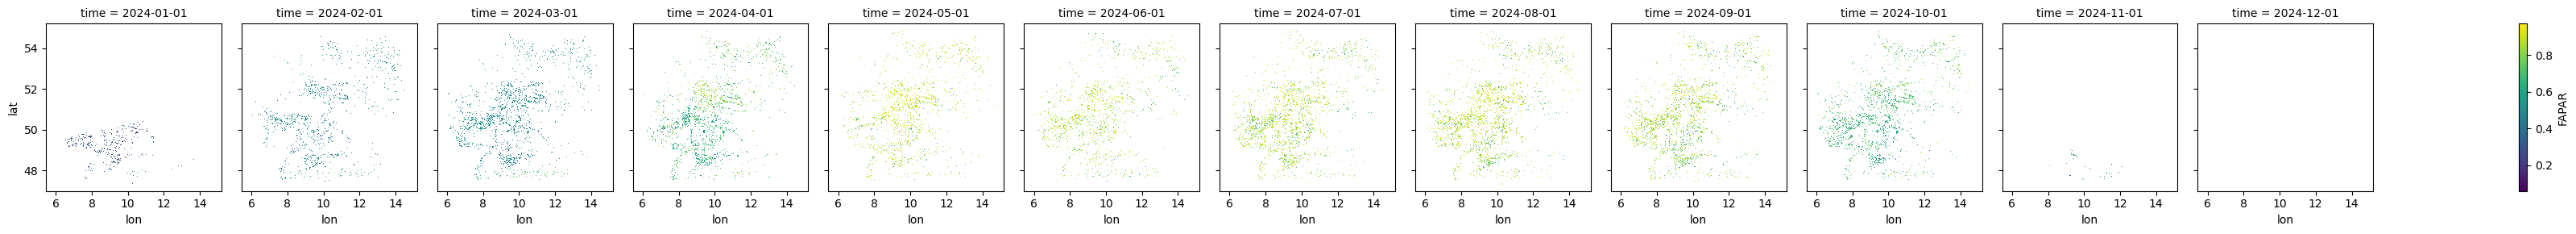

In [8]:
fapar_mon_mean.FAPAR.sel(time = slice('2024-01', '2024-12')).plot(col="time")

In [9]:
fapar_year_mean

<xarray.Dataset> Size: 83MB
Dimensions:      (time: 1, lat: 2952, lon: 3510)
Coordinates:
    crs          int8 1B -127
    spatial_ref  int64 8B 0
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables:
    FAPAR        (time, lat, lon) float64 83MB dask.array<chunksize=(1, 1476, 1755), meta=np.ndarray>

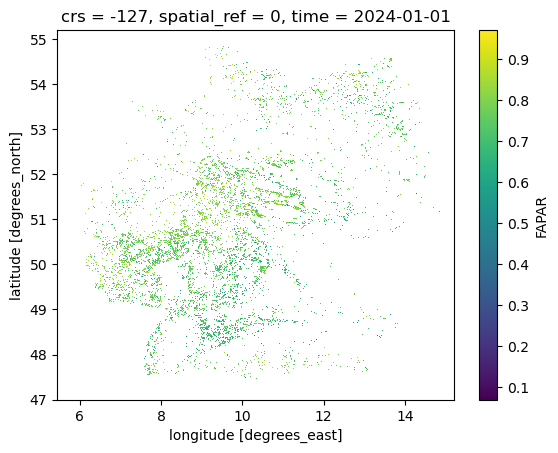

In [10]:
fapar_year_mean.FAPAR.plot()

In [11]:
# spatially aggregate yearly fapar data
# to get mean values for Germany and federal states

In [12]:
# first, get values for broadleaved forest
# load all yearly fapar values as one dataset
directory = f"./FAPAR/Yearly"
filelist = glob.glob(os.path.join(directory, "*BL*.nc"))
fapar_yearly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

In [13]:
# calculate mean fapar values per year for Germany
fapar_yearly_spatial_means = fapar_yearly.mean(['lon','lat'], skipna=True).to_dataframe()
fapar_yearly_spatial_means

,FAPAR,spatial_ref,crs
time,,,
1981-01-01,0.474941,0,-127
1982-01-01,0.430126,0,-127
1983-01-01,0.462998,0,-127
1984-01-01,0.476930,0,-127
1985-01-01,0.543727,0,-127
1986-01-01,0.474851,0,-127
1987-01-01,0.468027,0,-127
1988-01-01,0.446484,0,-127
1989-01-01,0.484596,0,-127


In [14]:
# drop unneeded columns
fapar_yearly_spatial_means = fapar_yearly_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

In [15]:
# rename column with fapar value to show area
fapar_yearly_spatial_means.rename({"FAPAR":"GER"}, axis=1, inplace=True)

In [16]:
# now, calculate yearly mean fapar values for all federal states
# get list of shapefiles of all states
directory = "./Administrative_Borders"
files = list(pathlib.Path(directory).glob('*.shp'))

# loop over filelist to process each state
for f in range(len(files)):
    file = files[f]

    # load state shapefile 
    state = str(file)[23:25]
    state_shp = gpd.read_file(file)

    # reproject shapefile to match netcdf data
    state_shp = state_shp.to_crs(4326)

    # extract one date to create mask of state with dimensions of data
    fapar_ex = fapar_yearly.sel(time = "1999-01-01", method = "nearest")

    # create mask of research area using the dimensions of the exemplary data
    state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                out_shape=fapar_ex.odc.geobox.shape,
                                                transform=fapar_ex.odc.geobox.affine,
                                                all_touched=False,
                                                invert=False)
    
    state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

    # mask yearly fapar data
    fapar_state = fapar_yearly["FAPAR"].where(~state_mask)

    # calculate yearly mean fapar of state and extract to dataframe
    fapar_state_spatial_means = fapar_state.mean(['lon','lat'], skipna=True).to_dataframe()

    # drop unneeded columns
    fapar_state_spatial_means = fapar_state_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

    # add yearly mean fapar values of state to dataframe
    fapar_yearly_spatial_means[state] = fapar_state_spatial_means["FAPAR"]   

In [17]:
fapar_yearly_spatial_means

,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
time,,,,,,,,,,,,,,,,,
1981-01-01,0.474941,0.445020,0.338506,0.479445,0.479385,0.507202,0.482127,0.454850,0.448121,0.478293,0.512726,0.471856,0.486896,0.459086,0.420496,0.442689,0.454508
1982-01-01,0.430126,0.394640,0.290893,0.453957,0.429546,0.420165,0.440122,0.418775,0.442530,0.410065,0.433031,0.446052,0.499820,0.424745,0.329224,0.343966,0.374300
1983-01-01,0.462998,0.441131,0.326481,0.464258,0.466675,0.438373,0.483906,0.414905,0.448547,0.455204,0.470862,0.475413,0.481034,0.445327,0.390941,0.416199,0.428559
1984-01-01,0.476930,0.423369,0.350247,0.504925,0.478771,0.434623,0.478871,0.432447,0.446781,0.469102,0.481487,0.480745,0.512971,0.469313,0.417019,0.434279,0.469346
1985-01-01,0.543727,0.454589,0.331307,0.564187,0.569924,0.499658,0.564822,0.476180,0.492674,0.525846,0.531105,0.563497,0.537300,0.517365,0.451008,0.479561,0.532822
1986-01-01,0.474851,0.397150,0.304681,0.508399,0.479311,0.406276,0.491870,0.396109,0.409227,0.472363,0.478279,0.490428,0.460127,0.456299,0.361811,0.421254,0.458172
1987-01-01,0.468027,0.436725,0.332961,0.476528,0.486816,0.468348,0.485939,0.402553,0.451228,0.459168,0.448382,0.467078,0.445107,0.468295,0.422578,0.436980,0.468142
1988-01-01,0.446484,0.393243,0.324958,0.446571,0.462387,0.411147,0.464749,0.409991,0.416668,0.446260,0.439674,0.453707,0.476426,0.481772,0.384693,0.387655,0.431963
1989-01-01,0.484596,0.397274,0.283492,0.490360,0.495367,0.426959,0.502748,0.428572,0.451282,0.481051,0.495360,0.523249,0.559749,0.480167,0.366521,0.396396,0.410586


In [18]:
# save as csv dataset
fapar_yearly_spatial_means.to_csv("./Tables/Spatial_Means/FAPAR_Yearly_Spatial_Means_BL.csv")

In [19]:
# now take the same steps for needleleaved forest
# load all yearly fapar values as one dataset
directory = f"./FAPAR/Yearly"
filelist = glob.glob(os.path.join(directory, "*NL*.nc"))
fapar_yearly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

In [20]:
# calculate mean fapar values per year for Germany
fapar_yearly_spatial_means = fapar_yearly.mean(['lon','lat'], skipna=True).to_dataframe()

In [21]:
# drop unneeded columns
fapar_yearly_spatial_means = fapar_yearly_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

In [22]:
# rename column with fapar value to show area
fapar_yearly_spatial_means.rename({"FAPAR":"GER"}, axis=1, inplace=True)

In [23]:
# now, calculate yearly mean fapar values for all federal states
# get list of shapefiles of all states
directory = "./Administrative_Borders"
files = list(pathlib.Path(directory).glob('*.shp'))

# loop over filelist to process each state
for f in range(len(files)):
    file = files[f]

    # load state shapefile 
    state = str(file)[23:25]
    state_shp = gpd.read_file(file)

    # reproject shapefile to match netcdf data
    state_shp = state_shp.to_crs(4326)

    # extract one date to create mask of state with dimensions of data
    fapar_ex = fapar_yearly.sel(time = "1999-01-01", method = "nearest")

    # create mask of research area using the dimensions of the exemplary data
    state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                out_shape=fapar_ex.odc.geobox.shape,
                                                transform=fapar_ex.odc.geobox.affine,
                                                all_touched=False,
                                                invert=False)
    
    state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

    # mask yearly fapar data
    fapar_state = fapar_yearly["FAPAR"].where(~state_mask)

    # calculate yearly mean fapar of state and extract to dataframe
    fapar_state_spatial_means = fapar_state.mean(['lon','lat'], skipna=True).to_dataframe()

    # drop unneeded columns
    fapar_state_spatial_means = fapar_state_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

    # add yearly mean fapar values of state to dataframe
    fapar_yearly_spatial_means[state] = fapar_state_spatial_means["FAPAR"]   

In [24]:
fapar_yearly_spatial_means

,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
time,,,,,,,,,,,,,,,,,
1981-01-01,0.494107,0.435975,0.351674,0.546843,0.500325,0.491916,0.521359,0.427872,0.437715,0.502823,0.594331,0.510756,0.479010,0.464945,0.486942,0.454074,0.504585
1982-01-01,0.420823,0.379396,0.308945,0.501585,0.426200,0.405193,0.442306,0.366620,0.434071,0.420264,0.467712,0.461888,0.484898,0.435225,0.380871,0.366305,0.396953
1983-01-01,0.461834,0.425928,0.353741,0.523965,0.476348,0.468575,0.480729,0.379593,0.447890,0.459663,0.503994,0.497487,0.480860,0.465735,0.421634,0.426542,0.434880
1984-01-01,0.466988,0.412203,0.354809,0.551748,0.480045,0.452014,0.485310,0.402019,0.432156,0.474302,0.501308,0.505491,0.496679,0.480170,0.423559,0.430882,0.473161
1985-01-01,0.512200,0.427334,0.345880,0.581323,0.541920,0.460093,0.562341,0.406411,0.477867,0.512769,0.569626,0.569865,0.542740,0.533474,0.477554,0.459818,0.528095
1986-01-01,0.441474,0.373794,0.324540,0.542882,0.451098,0.384632,0.492794,0.354301,0.401452,0.439555,0.518249,0.489126,0.447792,0.463143,0.391546,0.390663,0.448415
1987-01-01,0.447427,0.401389,0.344578,0.491563,0.468664,0.443415,0.489366,0.356312,0.437800,0.446135,0.461992,0.474793,0.446243,0.456343,0.411139,0.406009,0.465444
1988-01-01,0.421157,0.382302,0.356571,0.449489,0.424083,0.427188,0.461711,0.400520,0.399157,0.443384,0.464953,0.458470,0.488079,0.489675,0.392614,0.379633,0.428885
1989-01-01,0.460902,0.383440,0.294558,0.574587,0.480320,0.495187,0.503958,0.379646,0.426221,0.480057,0.534497,0.550402,0.543125,0.490364,0.383310,0.400544,0.419530


In [25]:
# save as csv dataset
fapar_yearly_spatial_means.to_csv("./Tables/Spatial_Means/FAPAR_Yearly_Spatial_Means_NL.csv")